# Breast Cancer Prediction from clinical data

Dataset: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29

Ref:https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/2-custom_and_distributed_training/week-2/C2W2_Assignment.ipynb

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

tf.get_logger().setLevel('ERROR')


In [29]:


DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
data_file = tf.keras.utils.get_file("breast_cancer.csv", DATASET_URL)
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
df = pd.read_csv(data_file, names=col_names, header=None)



In [30]:
df.head().transpose()

,0,1,2,3,4
id,1000025,1002945,1015425,1016277,1017023
clump_thickness,5,5,3,6,4
un_cell_size,1,4,1,8,1
un_cell_shape,1,4,1,8,1
marginal_adheshion,1,5,1,1,3
single_eph_cell_size,2,7,2,3,2
bare_nuclei,1,10,2,4,1
bland_chromatin,3,3,3,3,3
normal_nucleoli,1,2,1,7,1
mitoses,1,1,1,1,1


In [31]:
df.dropna(inplace=True)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,699.0,1.071704e+06,617095.729819,61634.0,870688.5,1171710.0,1238298.0,13454352.0
clump_thickness,699.0,4.417740e+00,2.815741,1.0,2.0,4.0,6.0,10.0
un_cell_size,699.0,3.134478e+00,3.051459,1.0,1.0,1.0,5.0,10.0
un_cell_shape,699.0,3.207439e+00,2.971913,1.0,1.0,1.0,5.0,10.0
marginal_adheshion,699.0,2.806867e+00,2.855379,1.0,1.0,1.0,4.0,10.0
single_eph_cell_size,699.0,3.216023e+00,2.214300,1.0,2.0,2.0,4.0,10.0
bland_chromatin,699.0,3.437768e+00,2.438364,1.0,2.0,3.0,5.0,10.0
normal_nucleoli,699.0,2.866953e+00,3.053634,1.0,1.0,1.0,4.0,10.0
mitoses,699.0,1.589413e+00,1.715078,1.0,1.0,1.0,1.0,10.0
class,699.0,2.689557e+00,0.951273,2.0,2.0,2.0,4.0,4.0


In [32]:
# so we only have two classes 2 and 4, we dont have 3. 2 is for benign and 4 for malignant
for i in df['class']:
    if i !=2 and i!=4:
        print(i) # shouldn't print anything since we have 2 and 4 only, two unique classes



In [33]:
df.pop('id') # dont need id for training
df.columns

Index(['clump_thickness', 'un_cell_size', 'un_cell_shape',
       'marginal_adheshion', 'single_eph_cell_size', 'bare_nuclei',
       'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class'],
      dtype='object')

In [34]:
df.bare_nuclei.describe()

count     699
unique     11
top         1
freq      402
Name: bare_nuclei, dtype: object

In [35]:
set(df.bare_nuclei)

{'1', '10', '2', '3', '4', '5', '6', '7', '8', '9', '?'}

In [36]:
# we need to drop rows with '?' elements in them 
df = df[df["bare_nuclei"] != '?' ]
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)

df.bare_nuclei

0       1
1      10
2       2
3       4
4       1
       ..
694     2
695     1
696     3
697     4
698     5
Name: bare_nuclei, Length: 683, dtype: int64

In [37]:
def format_class(class_number):
    '''Bengin breast cancer gets mapped to False and Malignant cancer gets mapped to True'''
    if class_number == 2:
        return 0
    elif class_number == 4:
        return 1
    else:
        raise Exception("unknown class")
df['class'] = df['class'].map(format_class)


In [38]:
train, test = train_test_split(df, test_size = 0.2)

train_stats = train.describe()
train_stats.pop('class')
train_stats = train_stats.transpose()

train_Y = train.pop("class")
test_Y = test.pop("class")

In [39]:
# normalization equation: X = (X - mean(X)) / StandardDeviation(X)
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

norm_train_X = norm(train)
norm_test_X = norm(test)

In [40]:


train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)

test_dataset =  test_dataset.batch(batch_size=batch_size)

# a = enumerate(train_dataset)

# print(len(list(a)))

In [52]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))

    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()



In [53]:
pred = model(norm_test_X.values)

pred = tf.reshape(pred, pred.shape[0])# because shape pred is [541, 1] instead of 541
assert pred.shape == test_Y.shape

loss_val = loss_object(y_true=test_Y.values, y_pred=pred)
print('test loss b4 training: %.4f'%loss_val.numpy())

test loss b4 training: 0.6590


In [43]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig=plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()



/home/mo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/mo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


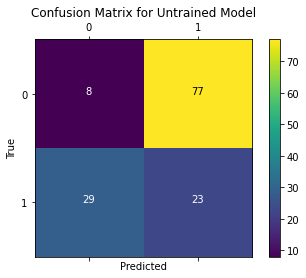

In [44]:
assert test_Y.values.shape == tf.round(pred).shape
plot_confusion_matrix(test_Y.values, tf.round(pred), title='Confusion Matrix for Untrained Model')


Define Custom F1Score Metric

In this example, we will define a custom F1Score metric using the formula.

F1 Score = 2 ((precision recall) / (precision + recall))

precision = true_positives / (true_positives + false_positives)

recall = true_positives / (true_positives + false_negatives)

We use confusion_matrix defined in tf.math to calculate precision and recall.

Here you can see that we have subclassed tf.keras.Metric and implemented the three required methods update_state, result and reset_states.

In [67]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs) -> None:
        super(F1Score, self).__init__(name=name, **kwargs)

        #true positives
        self.tp = tf.Variable(0, dtype='int32')

        #false positives
        self.fp = tf.Variable(0,dtype='int32')

        # true negatives
        self.tn = tf.Variable(0,dtype='int32')

        #false negatives
        self.fn = tf.Variable(0,dtype='int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)
        # Update values of true positives, true negatives, false positives and false negatives from confusion matrix.
        self.tn.assign_add(conf_matrix[0][0])
        self.tp.assign_add(conf_matrix[1][1])
        self.fp.assign_add(conf_matrix[0][1])
        self.fn.assign_add(conf_matrix[1][0])


    def result(self):
        '''Computes and returns the metric value tensor.'''

        # Calculate precision
        if (self.tp + self.fp == 0):
            precision = 1.0
        else:
            precision = self.tp / (self.tp + self.fp)
      
        # Calculate recall
        if (self.tp + self.fn == 0):
            recall = 1.0
        else:
            recall = self.tp / (self.tp + self.fn)

        # Return F1 Score
        ### START CODE HERE ###
        f1_score = 2 * (precision * recall) / (precision + recall)
        ### END CODE HERE ###
        
        return f1_score

    def reset_states(self):
        '''Resets all of the metric state variables.'''
        
        # The state of the metric will be reset at the start of each epoch.
        self.tp.assign(0)
        self.tn.assign(0) 
        self.fp.assign(0)
        self.fn.assign(0)


In [68]:

test_F1Score = F1Score()

test_F1Score.tp = tf.Variable(2, dtype = 'int32')
test_F1Score.fp = tf.Variable(5, dtype = 'int32')
test_F1Score.tn = tf.Variable(7, dtype = 'int32')
test_F1Score.fn = tf.Variable(9, dtype = 'int32')
test_F1Score.result()

<tf.Tensor: shape=(), dtype=float64, numpy=0.2222222222222222>

In [69]:
train_f1score_metric = F1Score()
val_f1score_metric = F1Score()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()


In [70]:
def apply_gradient(optimizer, loss_object, model, x, y):
    '''
    applies the gradients to the trainable model weights
    
    Args:
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        x: input data to the model
        y: target values for each input
    '''
    
    with tf.GradientTape() as tape:
    ### START CODE HERE ###
        logits = model(x) 
        loss_value = loss_object(y_true = y, y_pred = logits)
  
    gradients = tape.gradient(loss_value , model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights)) 
    return logits, loss_value
  

In [71]:
def train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, 
                             train_acc_metric, train_f1score_metric, verbose=True):
    '''
    Computes the loss then updates the weights and metrics for one epoch.
    
    Args:
        train_dataset: the training dataset
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        train_acc_metric: calculates how often predictions match labels
        train_f1score_metric: custom metric we defined earlier
    '''
    losses = []

    #Iterate through all batches of training data
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        #Calculate loss and update trainable variables using optimizer
        ### START CODE HERE ###
        logits, loss_value = apply_gradient(optimizer, loss_object, model, x_batch_train, y_batch_train)
        losses.append(loss_value)
        ### END CODE HERE ###

        #Round off logits to nearest integer and cast to integer for calulating metrics
        logits = tf.round(logits)
        logits = tf.cast(logits, 'int64')

        #Update the training metrics
        ### START CODE HERE ###
        train_acc_metric.update_state(y_batch_train, logits)
        train_f1score_metric.update_state(y_batch_train, logits)
        ### END CODE HERE ###

        #Update progress
        if verbose:
            print("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
    
    return losses

In [72]:
def perform_validation():
    losses = []

    #Iterate through all batches of validation data.
    for x_val, y_val in test_dataset:

        #Calculate validation loss for current batch.
        val_logits = model(x_val) 
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)

        #Round off and cast outputs to either  or 1
        val_logits = tf.cast(tf.round(model(x_val)), 'int64')

        #Update validation metrics
        val_acc_metric.update_state(y_val, val_logits)
        val_f1score_metric.update_state(y_val, val_logits)
        
    return losses

In [73]:
# Perform training over all batches of training data.
# Get values of metrics.
# Perform validation to calculate loss and update validation metrics on test data.
# Reset the metrics at the end of epoch.
# Display statistics at the end of each epoch.


# Iterate over epochs.
epochs = 5
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))
    
    # Perform Training over all batches of train data
    losses_train = train_data_for_one_epoch(
        train_dataset,
        optimizer,
        loss_object,
        model,
        train_acc_metric,
        train_f1score_metric,
    )

    # Get results from training metrics
    train_acc = train_acc_metric.result()
    train_f1score = train_f1score_metric.result()

    # Perform validation on all batches of test data
    losses_val = perform_validation()

    # Get results from validation metrics
    val_acc = val_acc_metric.result()
    val_f1score = val_f1score_metric.result()

    # Calculate training and validation losses for current epoch
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print(
        "\n Epcoh %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4f"
        % (
            epoch,
            float(losses_train_mean),
            float(losses_val_mean),
            float(train_acc),
            float(val_acc),
            train_f1score,
            val_f1score,
        )
    )

    # Reset states of all metrics
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()
    val_f1score_metric.reset_states()
    train_f1score_metric.reset_states()


Start of epoch 0
Training loss for step 0: 0.2985
Training loss for step 1: 0.2289
Training loss for step 2: 0.2754
Training loss for step 3: 0.2363
Training loss for step 4: 0.2236
Training loss for step 5: 0.1446
Training loss for step 6: 0.1556
Training loss for step 7: 0.1766
Training loss for step 8: 0.1448
Training loss for step 9: 0.0877
Training loss for step 10: 0.1200
Training loss for step 11: 0.1739
Training loss for step 12: 0.1420
Training loss for step 13: 0.1023
Training loss for step 14: 0.1234
Training loss for step 15: 0.0622
Training loss for step 16: 0.0828
Training loss for step 17: 1.2836

 Epcoh 0: Train loss: 0.2257  Validation Loss: 0.1063, Train Accuracy: 0.9427, Validation Accuracy 0.9812, Train F1 Score: 0.9526, Validation F1 Score: 0.9703
Start of epoch 1
Training loss for step 0: 0.1213
Training loss for step 1: 0.0800
Training loss for step 2: 0.1339
Training loss for step 3: 0.0909
Training loss for step 4: 0.1761
Training loss for step 5: 0.1384
Traini

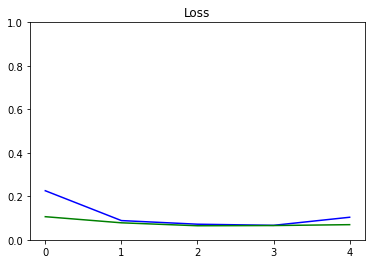

In [74]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

/home/mo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/mo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


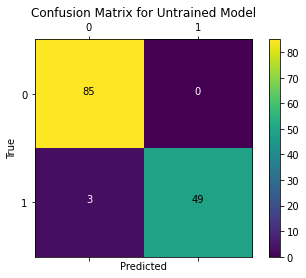

In [75]:
test_outputs = model(norm_test_X.values)
plot_confusion_matrix(test_Y.values, tf.round(test_outputs), title='Confusion Matrix for Untrained Model')
